# Thermodynamic Properties of Ising Models

Adapted from [https://cossio.github.io/IsingModels.jl/stable/literate/wolff/](https://cossio.github.io/IsingModels.jl/stable/literate/wolff/). 

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from isax import (
    BlockGraph,
    Edge,
    IsingModel,
    IsingSampler,
    magnetization_per_site,
    Node,
    sample_chain,
    SamplingArgs,
)
from scipy.special import ellipe, ellipk

In [2]:
def create_2d_ising_graph(L, J=1.0, h=0.0):
    num_sites = L * L
    nodes = [Node() for _ in range(num_sites)]

    edges, edge_weights = [], []
    for x in range(L):
        for y in range(L):
            i = x * L + y
            j = x * L + ((y + 1) % L)
            k = ((x + 1) % L) * L + y
            edges.append(Edge(nodes[i], nodes[j]))
            edges.append(Edge(nodes[i], nodes[k]))
            edge_weights.extend([J, J])

    edge_weights = jnp.array(edge_weights, dtype=float)
    node_biases = jnp.full(num_sites, h, dtype=float)

    even_nodes, odd_nodes = [], []
    for x in range(L):
        for y in range(L):
            (even_nodes if (x + y) % 2 == 0 else odd_nodes).append(nodes[x * L + y])

    blocks = [even_nodes, odd_nodes]
    graph = BlockGraph(blocks, edges)

    return graph, edge_weights, node_biases, edges


beta_c = np.log(1 + np.sqrt(2)) / 2
T_c = 1.0 / beta_c


def onsager_magnetization(beta):
    beta = np.asarray(beta)
    csch_val = 1.0 / np.sinh(2 * beta)
    return np.where(
        beta >= beta_c, np.power(np.maximum(1 - csch_val**4, 0), 1 / 8), 0.0
    )


def onsager_internal_energy(beta):
    beta = np.asarray(beta)
    k = 2 * np.tanh(2 * beta) / np.cosh(2 * beta)
    j = 2 * np.tanh(2 * beta) ** 2 - 1
    K = ellipk(k**2)
    return -1 / np.tanh(2 * beta) * (1 + 2 / np.pi * j * K)


def onsager_heat_capacity(beta):
    beta = np.asarray(beta)
    k = 2 * np.tanh(2 * beta) / np.cosh(2 * beta)
    K = ellipk(k**2)
    E = ellipe(k**2)
    j = 2 * np.tanh(2 * beta) ** 2 - 1
    return (
        beta**2
        * (1 / np.tanh(2 * beta)) ** 2
        * (2 / np.pi)
        * (((j - 0.5) ** 2 + 7 / 4) * K - 2 * E - (1 - j) * np.pi / 2)
    )

## Magnetization vs Temperature for Different System Sizes

In [3]:
T = jnp.linspace(1.5, 3.0, 40)
betas = 1.0 / T
to_sample = [
    (4, "orange", "L=4"),
    (8, "green", "L=8"),
    (16, "blue", "L=16"),
    (32, "red", "L=32"),
]

key = jax.random.key(42)
sample_fn = eqx.filter_jit(sample_chain)

results = {}

for L, color, label in to_sample:
    print(f"Simulating {label}")
    graph, edge_weights, node_biases, edges = create_2d_ising_graph(L)
    edge_indices, edge_mask = graph.get_edge_structure()

    params = graph.get_sampling_params()
    sampling_args = SamplingArgs(
        gibbs_steps=4000,
        blocks_to_sample=[0, 1],
        data=params,
    )

    model = IsingModel(weights=edge_weights, biases=node_biases)
    sampler = IsingSampler()
    energy_fn_jit = eqx.filter_jit(model.energy)

    M_avg, E_avg, C_avg = [], [], []
    M_std, E_std, C_std = [], [], []

    for beta, temp in zip(betas, T):
        key, k_init, k_run = jax.random.split(key, 3)

        num_even = len([n for i, n in enumerate(graph.nodes) if i % 2 == 0])
        num_odd = L * L - num_even

        init_state = [
            jax.random.choice(k_init, jnp.array([1, -1]), shape=(num_even,)),
            jax.random.choice(k_init, jnp.array([1, -1]), shape=(num_odd,)),
        ]

        model_with_beta = IsingModel(
            weights=beta * edge_weights, biases=beta * node_biases
        )

        samples = sample_fn(
            init_state, [sampler, sampler], model_with_beta, sampling_args, k_run
        )

        equilibration = 500
        spins = jnp.concatenate(samples, axis=-1)[equilibration:]
        spins = spins[::5]

        mags = jnp.abs(magnetization_per_site(spins))
        energies = jax.vmap(energy_fn_jit, in_axes=(0, None, None))(
            spins, edge_indices, edge_mask
        ) / (L * L)

        M_avg.append(jnp.mean(mags))
        M_std.append(jnp.std(mags))
        E_avg.append(jnp.mean(energies))
        E_std.append(jnp.std(energies))
        C_avg.append(beta**2 * jnp.var(energies * L * L, ddof=1) / (L * L))

    results[(L, color, label)] = {
        "M_avg": jnp.array(M_avg),
        "M_std": jnp.array(M_std),
        "E_avg": jnp.array(E_avg),
        "E_std": jnp.array(E_std),
        "C_avg": jnp.array(C_avg),
    }

Simulating L=4
Simulating L=8
Simulating L=16
Simulating L=32


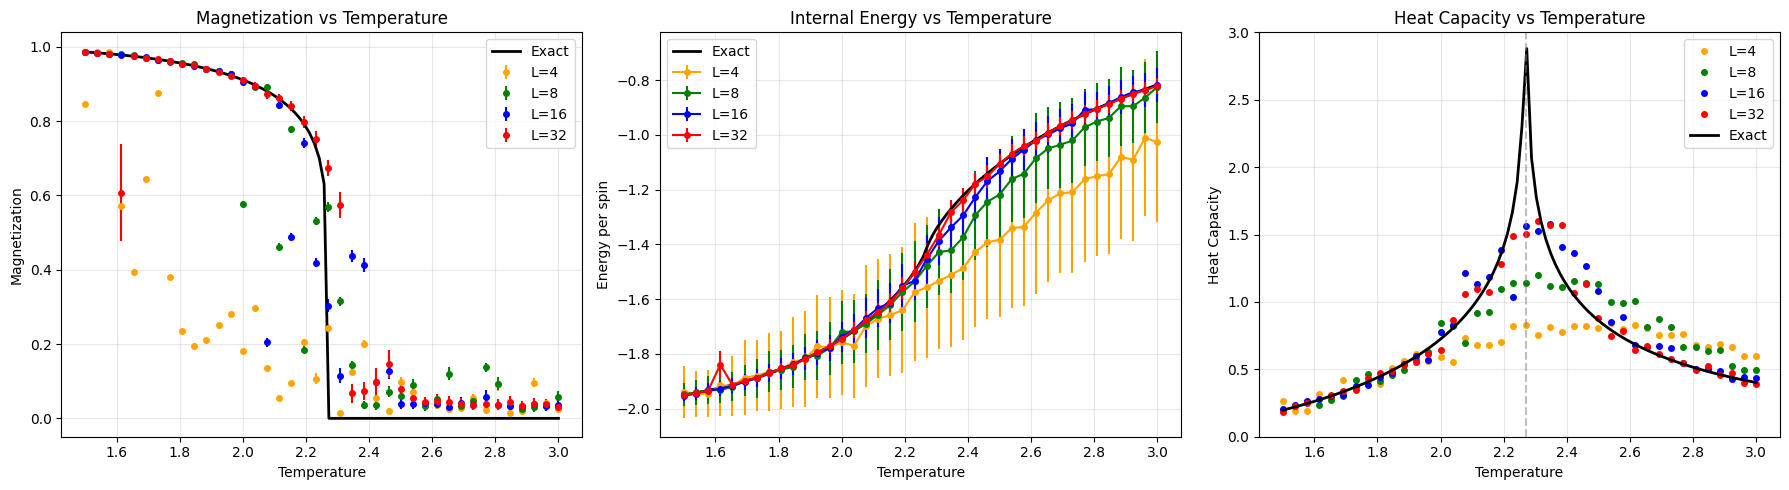

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for (L, color, label), data in results.items():
    axes[0].errorbar(
        T,
        data["M_avg"],
        yerr=data["M_std"] / 2,
        fmt="o",
        color=color,
        label=label,
        markersize=4,
        linestyle="None",
    )
    axes[1].errorbar(
        T,
        data["E_avg"],
        yerr=data["E_std"] / 2,
        fmt="o-",
        color=color,
        label=label,
        markersize=4,
    )
    axes[2].plot(
        T, data["C_avg"], "o", color=color, label=label, markersize=4, linestyle="None"
    )

T_theory = np.linspace(T.min(), T.max(), 100)
beta_theory = 1.0 / T_theory
M_theory = onsager_magnetization(beta_theory)
E_theory = onsager_internal_energy(beta_theory)
C_theory = onsager_heat_capacity(beta_theory)

axes[0].plot(T_theory, M_theory, "k-", label="Exact", linewidth=2)
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Magnetization")
axes[0].set_title("Magnetization vs Temperature")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(T_theory, E_theory, "k-", label="Exact", linewidth=2)
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Energy per spin")
axes[1].set_title("Internal Energy vs Temperature")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(T_theory, C_theory, "k-", label="Exact", linewidth=2)
axes[2].axvline(T_c, color="gray", linestyle="--", alpha=0.5)
axes[2].set_xlabel("Temperature")
axes[2].set_ylabel("Heat Capacity")
axes[2].set_title("Heat Capacity vs Temperature")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 3)

plt.tight_layout()
plt.show()

## Correlation Length Analysis

In [26]:
# todo: fix

# def compute_correlation_function(spins, max_r=None):
#     L = int(jnp.sqrt(spins.shape[-1]))
#     spins_2d = spins.reshape(-1, L, L)

#     if max_r is None:
#         max_r = L // 4
#     else:
#         max_r = min(max_r, L // 4)

#     correlations = []

#     mean_mag = jnp.mean(spins_2d)

#     for r in range(1, max_r + 1):
#         corr_h = jnp.mean(spins_2d[:, :, :] * jnp.roll(spins_2d, r, axis=2))
#         corr_v = jnp.mean(spins_2d[:, :, :] * jnp.roll(spins_2d, r, axis=1))
#         corr = (corr_h + corr_v) / 2 - mean_mag**2
#         correlations.append(corr)

#     return jnp.array(correlations)


# L = 32
# graph, edge_weights, node_biases, edges = create_2d_ising_graph(L, 1)

# params = graph.get_sampling_params()
# sampling_args = SamplingArgs(
#     gibbs_steps=2000,
#     blocks_to_sample=[0, 1],
#     data=params,
# )

# model = IsingModel(weights=edge_weights, biases=node_biases)
# sampler = IsingSampler()

# temperatures = np.linspace(1.5, 3.0, 10)

# correlation_results = {}

# for temp in temperatures:
#     print(f"Computing correlations at T={temp:.2f}")
#     beta = 1.0 / temp
#     key, k_init, k_run = jax.random.split(key, 3)

#     num_even = L * L // 2
#     num_odd = L * L - num_even

#     init_state = [
#         jax.random.choice(k_init, jnp.array([1, -1]), shape=(num_even,)),
#         jax.random.choice(k_init, jnp.array([1, -1]), shape=(num_odd,)),
#     ]

#     model_with_beta = IsingModel(weights=beta * edge_weights,
#                           biases=beta * node_biases)

#     samples = sample_fn(
#         init_state, [sampler, sampler], model_with_beta, sampling_args, k_run
#     )

#     spins = jnp.concatenate(samples, axis=-1)[1000::10]
#     correlations = compute_correlation_function(spins)

#     correlation_results[temp] = correlations

In [27]:
# fig, ax = plt.subplots(figsize=(7, 4))

# for (temp), correlations in correlation_results.items():
#     r = jnp.arange(1, len(correlations) + 1)
#     label = f"T={temp:.2f}"
#     ax.plot(r, jnp.abs(correlations), "o-", label=label)

# ax.set_xlabel("Distance")
# ax.set_ylabel("|C(r)|")
# ax.set_title("Spin-Spin Correlation Function")
# ax.legend()
# ax.grid(True, alpha=0.3)
# plt.show()

In [28]:
# todo: add ac analysis